Latitude:  27.1505
Longitude:  86.4334
Use Lat=27.150500, Lng=86.433400? (y/n):  y


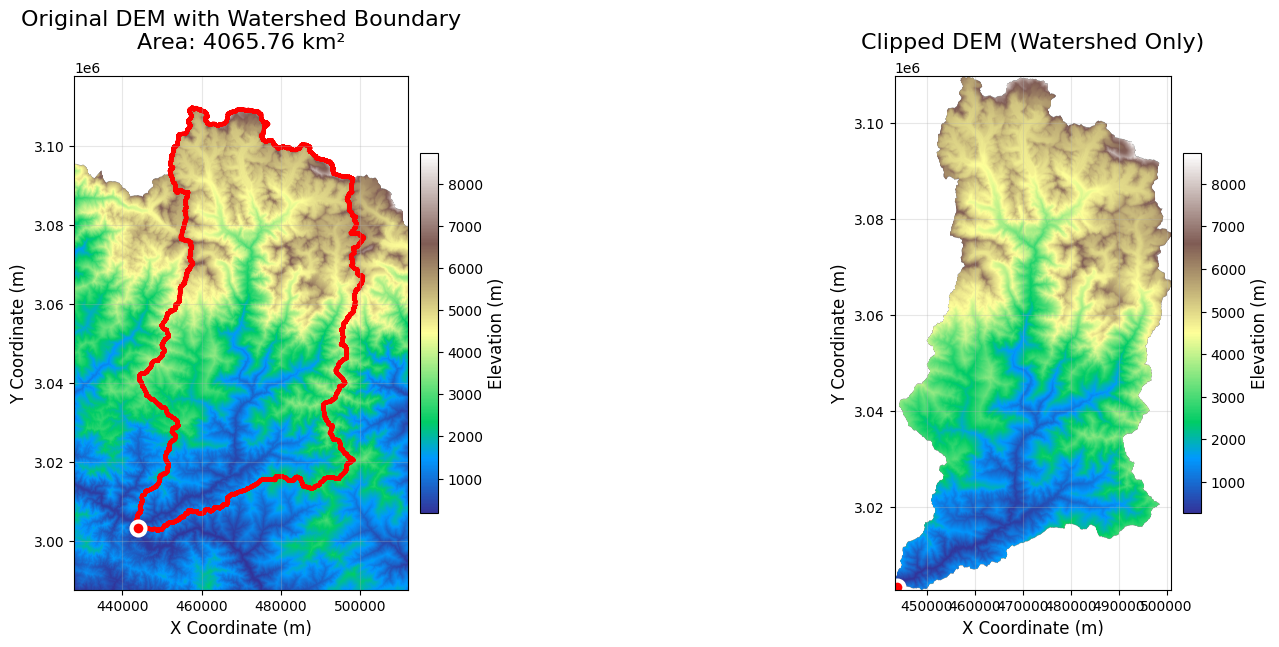

Processing geospatial analysis tools


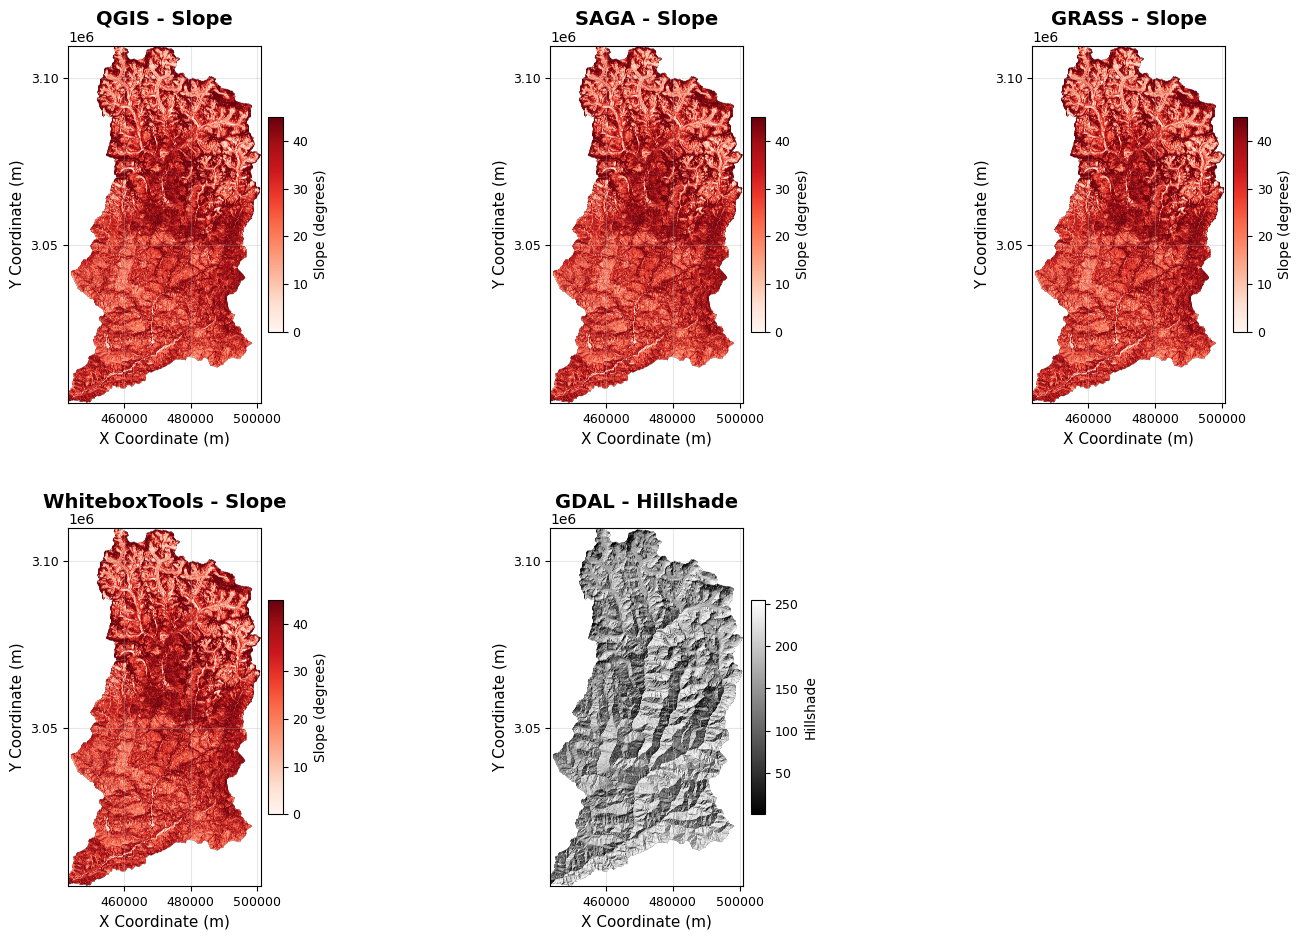

Analysis completed


In [ ]:
import json
import os
import numpy as np
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
import folium
from folium.plugins import MousePosition
from pyproj import Transformer
import warnings
warnings.filterwarnings('ignore')

with open('watershed_analysis.json', 'r') as f:
    config = json.load(f)

os.makedirs(config["temp_dir"], exist_ok=True)
os.makedirs(config["output_dir"], exist_ok=True)

class WatershedDelineator:
    def __init__(self, dem_path):
        self.dem_path = dem_path
        self.temp_dir = config["temp_dir"]
        
        with rasterio.open(dem_path) as src:
            self.cell_size = src.res[0]
            self.crs = src.crs
            bounds = src.bounds
            
            self.to_wgs84 = Transformer.from_crs(self.crs, config["target_crs"], always_xy=True)
            self.from_wgs84 = Transformer.from_crs(config["target_crs"], self.crs, always_xy=True)
            
            minx, miny = self.to_wgs84.transform(bounds.left, bounds.bottom)
            maxx, maxy = self.to_wgs84.transform(bounds.right, bounds.top)
            self.bounds_wgs84 = {'minx': minx, 'miny': miny, 'maxx': maxx, 'maxy': maxy}
    
    def get_pour_point(self):
        center_lat = (self.bounds_wgs84['miny'] + self.bounds_wgs84['maxy']) / 2
        center_lng = (self.bounds_wgs84['minx'] + self.bounds_wgs84['maxx']) / 2
        
        m = folium.Map(location=[center_lat, center_lng], zoom_start=config["default_zoom"])
        
        folium.TileLayer(
            tiles=config["tile_layer"],
            attr=config["tile_attribution"], 
            name='OpenStreetMap'
        ).add_to(m)
        
        bounds_coords = [
            [self.bounds_wgs84['miny'], self.bounds_wgs84['minx']],
            [self.bounds_wgs84['miny'], self.bounds_wgs84['maxx']],
            [self.bounds_wgs84['maxy'], self.bounds_wgs84['maxx']],
            [self.bounds_wgs84['maxy'], self.bounds_wgs84['minx']]
        ]
        folium.Polygon(bounds_coords, 
                      color=config["boundary_color"], 
                      weight=config["boundary_weight"], 
                      fill=True, fillOpacity=0.1).add_to(m)
        
        MousePosition().add_to(m)
        folium.LatLngPopup().add_to(m)
        folium.LayerControl().add_to(m)
        
        try:
            from IPython.display import display
            display(m)
        except ImportError:
            m.save("pour_point_map.html")
            print("Map saved to pour_point_map.html")
        
        while True:
            try:
                lat = float(input("Latitude: ").strip())
                lng = float(input("Longitude: ").strip())
                
                if (self.bounds_wgs84['miny'] <= lat <= self.bounds_wgs84['maxy'] and 
                    self.bounds_wgs84['minx'] <= lng <= self.bounds_wgs84['maxx']):
                    if input(f"Use Lat={lat:.6f}, Lng={lng:.6f}? (y/n): ").lower() == 'y':
                        return lat, lng
            except ValueError:
                continue
    
    def delineate_watershed(self, lat, lng):
        try:
            import whitebox
        except ImportError:
            return None, None
        
        x_proj, y_proj = self.from_wgs84.transform(lng, lat)
        
        gdf = gpd.GeoDataFrame({'id': [1]}, geometry=gpd.points_from_xy([x_proj], [y_proj]), crs=self.crs)
        pour_point_path = os.path.join(self.temp_dir, 'pour_point.shp')
        gdf.to_file(pour_point_path)
        
        wbt = whitebox.WhiteboxTools()
        wbt.set_verbose_mode(config["verbose_mode"])
        wbt.set_working_dir(os.path.abspath(self.temp_dir))
        
        import shutil
        shutil.copy2(self.dem_path, os.path.join(self.temp_dir, 'dem.tif'))
        
        if config["depression_filling"]:
            wbt.fill_depressions('dem.tif', 'dem_filled.tif')
        else:
            shutil.copy2('dem.tif', 'dem_filled.tif')
            
        wbt.d8_pointer('dem_filled.tif', 'd8_pointer.tif')
        wbt.d8_flow_accumulation('d8_pointer.tif', 'flow_accum.tif', pntr=True)
        
        threshold = max(config["flow_accumulation_threshold"], 
                       int(config["minimum_threshold"] / (self.cell_size * self.cell_size)))
        wbt.extract_streams('flow_accum.tif', 'streams.tif', threshold)
        
        snap_distance = self.cell_size * config["snap_distance_multiplier"]
        wbt.jenson_snap_pour_points('pour_point.shp', 'streams.tif', 'pour_point_snapped.shp', snap_distance)
        wbt.watershed('d8_pointer.tif', 'pour_point_snapped.shp', 'watershed.tif')
        
        watershed_vector = self._raster_to_vector()
        clipped_dem = self._clip_dem_with_watershed(watershed_vector)
        
        return watershed_vector, clipped_dem
    
    def _raster_to_vector(self):
        watershed_raster = os.path.join(self.temp_dir, 'watershed.tif')
        
        try:
            from rasterio.features import shapes
            
            with rasterio.open(watershed_raster) as src:
                data = src.read(1)
                transform = src.transform
                crs = src.crs
            
            polygons = []
            for geom, value in shapes(data.astype(np.int32), mask=data > 0, transform=transform):
                if value > 0:
                    polygons.append(shape(geom))
            
            if polygons:
                gdf = gpd.GeoDataFrame({'watershed_id': range(len(polygons))}, geometry=polygons)
                gdf.set_crs(crs, inplace=True)
                
                vector_path = os.path.join(self.temp_dir, 'watershed_vector.shp')
                gdf.to_file(vector_path)
                return vector_path
                
        except Exception:
            return None
    
    def _clip_dem_with_watershed(self, watershed_vector):
        if not watershed_vector:
            return None
            
        try:
            watershed_gdf = gpd.read_file(watershed_vector)
            
            with rasterio.open(self.dem_path) as src:
                out_image, out_transform = rasterio.mask.mask(src, watershed_gdf.geometry, crop=True)
                out_meta = src.meta.copy()
                
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })
                
                clipped_dem_path = os.path.join(self.temp_dir, 'clipped_dem.tif')
                with rasterio.open(clipped_dem_path, "w", **out_meta) as dest:
                    dest.write(out_image)
                
                return clipped_dem_path
                
        except Exception:
            return None
    
    def visualize_results(self, watershed_vector, clipped_dem, lat, lng):
        if not watershed_vector or not clipped_dem:
            return
        
        x_proj, y_proj = self.from_wgs84.transform(lng, lat)
        
        with rasterio.open(self.dem_path) as src:
            original_dem = src.read(1, masked=True)
            original_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        with rasterio.open(clipped_dem) as src:
            clipped_data = src.read(1, masked=True)
            clipped_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        watershed_gdf = gpd.read_file(watershed_vector)
        area_km2 = watershed_gdf.geometry.area.sum() / 1e6
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(config["figure_width"], config["figure_height"]/1.5))
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.3)
        
        im1 = ax1.imshow(original_dem, extent=original_extent, 
                        cmap=config["elevation_colormap"], aspect='equal')
        watershed_gdf.plot(ax=ax1, facecolor='none', 
                          edgecolor=config["boundary_color"], linewidth=3)
        ax1.scatter(x_proj, y_proj, c=config["pour_point_color"], 
                   s=config["pour_point_size"], marker='o', 
                   edgecolor='white', linewidth=3)
        ax1.set_title(f'Original DEM with Watershed Boundary\nArea: {area_km2:.2f} km²', 
                     fontsize=16, pad=20)
        ax1.set_xlabel('X Coordinate (m)', fontsize=12)
        ax1.set_ylabel('Y Coordinate (m)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.7, aspect=20, pad=0.02)
        cbar1.set_label('Elevation (m)', fontsize=12)
        
        im2 = ax2.imshow(clipped_data, extent=clipped_extent, 
                        cmap=config["elevation_colormap"], aspect='equal')
        ax2.scatter(x_proj, y_proj, c=config["pour_point_color"], 
                   s=config["pour_point_size"], marker='o', 
                   edgecolor='white', linewidth=3)
        ax2.set_title('Clipped DEM (Watershed Only)', fontsize=16, pad=20)
        ax2.set_xlabel('X Coordinate (m)', fontsize=12)
        ax2.set_ylabel('Y Coordinate (m)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.7, aspect=20, pad=0.02)
        cbar2.set_label('Elevation (m)', fontsize=12)
        
        viz_path = os.path.join(config["output_dir"], 'watershed_results.png')
        plt.savefig(viz_path, dpi=config["dpi"], bbox_inches='tight')
        plt.show()
        plt.close()
        
        import shutil
        shutil.copy2(watershed_vector, os.path.join(config["output_dir"], 'watershed.shp'))
        shutil.copy2(clipped_dem, os.path.join(config["output_dir"], 'clipped_dem.tif'))
        
        return viz_path

def saga_slope(input_dem, output_slope):
    import re
    import subprocess
    
    env = {
        'LD_LIBRARY_PATH': '/opt/saga/lib:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu:/opt/conda/envs/pygile/lib',
        'SAGA_MLB': config["saga_lib"]
    }
    
    result = subprocess.run([config["saga_cmd"]], capture_output=True, text=True, env=env)
    
    libraries = []
    for line in result.stdout.split('\n'):
        if line.startswith(' - '):
            lib_name = line[3:].strip().rstrip(' *')
            if lib_name and not lib_name.startswith('_'):
                libraries.append(lib_name)
    
    unique_libraries = list(dict.fromkeys(libraries))
    algorithms_data = []
    
    for lib in unique_libraries:
        result = subprocess.run([config["saga_cmd"], lib], capture_output=True, text=True, env=env)
        
        for line in result.stdout.split('\n'):
            match = re.match(r'^\s*\[(\d+)\]\s+(.+)', line)
            if match:
                tool_id = match.group(1)
                tool_name = match.group(2).strip()
                algorithms_data.append([lib, tool_id, tool_name])
    
    for lib, tool_id, tool_name in algorithms_data:
        if 'slope' in tool_name.lower() and config["slope_method"] in lib.lower():
            try:
                aspect_temp = output_slope.replace('.tif', '_aspect_temp.tif')
                subprocess.run([config["saga_cmd"], lib, tool_id, 
                              f"-ELEVATION={input_dem}", f"-SLOPE={output_slope}", 
                              f"-ASPECT={aspect_temp}", f"-UNIT_SLOPE={config['slope_unit_saga']}"], 
                             env=env, check=True, capture_output=True, text=True)
                if os.path.exists(aspect_temp):
                    os.remove(aspect_temp)
                return
            except:
                continue
    
    raise Exception("SAGA slope algorithm not found")

def grass_slope(input_dem, output_slope):
    import tempfile
    import shutil
    
    temp_dir_grass = tempfile.mkdtemp()
    gisdbase = os.path.join(temp_dir_grass, "grassdb")
    location = "temp_location"
    mapset = "PERMANENT"
    permanent_dir = os.path.join(gisdbase, location, mapset)
    
    os.makedirs(permanent_dir)
    
    gisrc = os.path.join(temp_dir_grass, "gisrc")
    with open(gisrc, 'w') as f:
        f.write(f"GISDBASE: {gisdbase}\nLOCATION_NAME: {location}\nMAPSET: {mapset}\n")
    
    with open(os.path.join(permanent_dir, "DEFAULT_WIND"), 'w') as f:
        f.write("proj: 0\nzone: 0\nnorth: 1\nsouth: 0\neast: 1\nwest: 0\n")
        f.write("cols: 1\nrows: 1\ne-w resol: 1\nn-s resol: 1\ntop: 1\nbottom: 0\n")
    
    shutil.copy2(os.path.join(permanent_dir, "DEFAULT_WIND"), 
                 os.path.join(permanent_dir, "WIND"))
    
    grass_env = os.environ.copy()
    grass_env['GISRC'] = gisrc
    grass_env['GISBASE'] = config["grass_bin"][:-4]
    grass_env['PATH'] = f'{config["grass_bin"]}:{config["grass_bin"]}:/usr/local/bin:/usr/bin:/bin'
    grass_env['LD_LIBRARY_PATH'] = f'{config["grass_bin"][:-4]}/lib'
    grass_env['GDAL_DATA'] = config["gdal_data_path"]
    grass_env['PROJ_LIB'] = config["proj_lib_path"]
    grass_env['GDAL_DRIVER_PATH'] = 'disable'
    grass_env['LC_ALL'] = config["locale"]
    
    try:
        import subprocess
        subprocess.run([f'{config["grass_bin"]}/r.in.gdal', 
                       f'input={input_dem}', 'output=dem', '--overwrite', '-o'], 
                      env=grass_env, check=True, capture_output=True)
        
        subprocess.run([f'{config["grass_bin"]}/g.region', 'raster=dem'], 
                      env=grass_env, check=True, capture_output=True)
        
        subprocess.run([f'{config["grass_bin"]}/r.slope.aspect', 
                       'elevation=dem', 'slope=slope_out', f'format={config["format_grass"]}', '--overwrite'], 
                      env=grass_env, check=True, capture_output=True)
        
        subprocess.run([f'{config["grass_bin"]}/r.out.gdal', 
                       'input=slope_out', f'output={output_slope}', '--overwrite'], 
                      env=grass_env, check=True, capture_output=True)
    finally:
        shutil.rmtree(temp_dir_grass)

def otb_edge_detection(input_dem, output_edges):
    otb_env = os.environ.copy()
    otb_env['PATH'] = f'{config["otb_bin"]}:/usr/local/bin:/usr/bin:/bin'
    otb_env['LD_LIBRARY_PATH'] = f'{config["otb_bin"][:-4]}/lib'
    otb_env['OTB_APPLICATION_PATH'] = f'{config["otb_bin"][:-4]}/lib/otb/applications'
    otb_env['GDAL_DATA'] = f'{config["otb_bin"][:-4]}/share/gdal'
    
    import subprocess
    try:
        if config["edge_filter_type"] == "sobel":
            subprocess.run([
                f'{config["otb_bin"]}/otbcli_EdgeExtraction',
                '-in', input_dem, 
                '-channel', str(config["edge_channel"]),
                '-filter', 'sobel', 
                '-filter.sobel.xradius', str(config["edge_x_radius"]), 
                '-filter.sobel.yradius', str(config["edge_y_radius"]), 
                '-out', output_edges, 'float'
            ], env=otb_env, check=True, capture_output=True)
        else:
            subprocess.run([
                f'{config["otb_bin"]}/otbcli_BandMath',
                '-il', input_dem,
                '-exp', 'sqrt((im1b1-im1b1[1,0])^2 + (im1b1-im1b1[0,1])^2)',
                '-out', output_edges, 'float'
            ], env=otb_env, check=True, capture_output=True)
    except:
        subprocess.run([
            f'{config["otb_bin"]}/otbcli_BandMath',
            '-il', input_dem,
            '-exp', 'sqrt((im1b1-im1b1[1,0])^2 + (im1b1-im1b1[0,1])^2)',
            '-out', output_edges, 'float'
        ], env=otb_env, check=True, capture_output=True)

def whitebox_slope(input_dem, output_slope):
    import subprocess
    subprocess.run([
        config["whitebox_tools"],
        '--run=Slope', f'--dem={input_dem}', f'--output={output_slope}',
        f'--units={config["slope_units"]}', '--verbose=false'
    ], check=True, capture_output=True)

def gdal_hillshade(input_dem, output_hillshade):
    gdal_env = os.environ.copy()
    gdal_env['PATH'] = f'{config["conda_env_path"]}/bin:/usr/local/bin:/usr/bin:/bin'
    gdal_env['LD_LIBRARY_PATH'] = f'{config["conda_env_path"]}/lib'
    
    import subprocess
    subprocess.run([
        f'{config["conda_env_path"]}/bin/gdaldem', 'hillshade',
        '-az', str(config["hillshade_azimuth"]),
        '-alt', str(config["hillshade_altitude"]),
        '-z', str(config["z_factor"]),
        '-s', str(config["hillshade_scale"]),
        input_dem, output_hillshade
    ], env=gdal_env, check=True, capture_output=True)

def visualize_slopes():
    import matplotlib.pyplot as plt
    import rasterio
    import numpy as np
    import gc
    
    slope_files = [
        ("saga_slope.tif", "SAGA - Slope", config["slope_colormap"]), 
        ("grass_slope.tif", "GRASS - Slope", config["slope_colormap"]),
        ("otb_edges.tif", "OTB - Edges", config["edge_colormap"]),
        ("wb_slope.tif", "WhiteboxTools - Slope", config["slope_colormap"]),
        ("hillshade.tif", "GDAL - Hillshade", config["hillshade_colormap"])
    ]
    
    existing_files = [(f, t, c) for f, t, c in slope_files if os.path.exists(f)]
    
    if not existing_files:
        return
    
    n_files = len(existing_files)
    if n_files <= 3:
        rows, cols = 1, n_files
        figsize = (config["figure_width"], config["figure_height"]/2)
    elif n_files <= 6:
        rows, cols = 2, 3
        figsize = (config["figure_width"], config["figure_height"])
    else:
        rows, cols = 3, 3
        figsize = (config["figure_width"]*1.2, config["figure_height"]*1.2)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08, wspace=0.25, hspace=0.35)
    
    if n_files == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for i, (filename, title, cmap) in enumerate(existing_files):
        try:
            with rasterio.open(filename) as src:
                data = src.read(1, masked=True)
                extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
                
                if "slope" in title.lower():
                    if "grass" in title.lower():
                        data = np.abs(data)
                    
                    vmin = config["slope_min_value"]
                    vmax = min(config["slope_max_absolute"], np.nanpercentile(data, config["slope_max_percentile"]))
                    im = axes[i].imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
                elif "edge" in title.lower():
                    if np.nanmax(data) > np.nanmin(data):
                        vmin, vmax = np.nanpercentile(data, [1, 99])
                        im = axes[i].imshow(data, cmap=cmap, extent=extent, aspect='equal', vmin=vmin, vmax=vmax)
                    else:
                        im = axes[i].imshow(np.zeros_like(data), cmap=cmap, extent=extent, aspect='equal')
                        axes[i].text(0.5, 0.5, 'No edges detected', 
                                   ha='center', va='center', transform=axes[i].transAxes,
                                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
                else:
                    im = axes[i].imshow(data, cmap=cmap, extent=extent, aspect='equal')
                
                axes[i].set_title(title, fontsize=14, fontweight='bold', pad=15)
                axes[i].set_xlabel('X Coordinate (m)', fontsize=11)
                axes[i].set_ylabel('Y Coordinate (m)', fontsize=11)
                
                axes[i].locator_params(axis='both', nbins=4)
                axes[i].tick_params(axis='both', which='major', labelsize=9)
                axes[i].grid(True, alpha=0.3)
                
                cbar = plt.colorbar(im, ax=axes[i], shrink=0.6, aspect=15, pad=0.02)
                if "slope" in title.lower():
                    cbar.set_label('Slope (degrees)', fontsize=10)
                elif "hillshade" in title.lower():
                    cbar.set_label('Hillshade', fontsize=10)
                elif "edge" in title.lower():
                    cbar.set_label('Edge Strength', fontsize=10)
                cbar.ax.tick_params(labelsize=9)
                
                del data
                gc.collect()
                
        except Exception:
            axes[i].text(0.5, 0.5, f"Error loading {filename}", 
            ha='center', va='center', transform=axes[i].transAxes,
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
            axes[i].set_title(title, fontsize=14, fontweight='bold')
            axes[i].axis('off')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    save_path = 'geospatial_analysis_results.png'
    plt.savefig(save_path, dpi=config["dpi"], bbox_inches='tight')
    plt.show()
    plt.close(fig)
    gc.collect()

def run_watershed_delineation():
    if not os.path.exists(config["dem_path"]):
        print(f"DEM file not found: {config['dem_path']}")
        return None, None
        
    delineator = WatershedDelineator(config["dem_path"])
    
    lat, lng = delineator.get_pour_point()
    watershed_vector, clipped_dem = delineator.delineate_watershed(lat, lng)
    
    if watershed_vector and clipped_dem:
        delineator.visualize_results(watershed_vector, clipped_dem, lat, lng)
        return watershed_vector, clipped_dem
    else:
        return None, None

def main():
    watershed_vector, clipped_dem = run_watershed_delineation()
    
    if watershed_vector and clipped_dem:
        import shutil
        final_watershed_dem = os.path.join(config["output_dir"], 'clipped_dem.tif')
        if not os.path.exists(final_watershed_dem):
            shutil.copy2(clipped_dem, final_watershed_dem)
        
        print("Processing geospatial analysis tools")
        
        tools = [
            ("SAGA", lambda: saga_slope(final_watershed_dem, "saga_slope.tif")),
            ("GRASS", lambda: grass_slope(final_watershed_dem, "grass_slope.tif")),
            ("OTB", lambda: otb_edge_detection(final_watershed_dem, "otb_edges.tif")),
            ("WhiteboxTools", lambda: whitebox_slope(final_watershed_dem, "wb_slope.tif")),
            ("GDAL", lambda: gdal_hillshade(final_watershed_dem, "hillshade.tif"))
        ]
        
        for tool_name, tool_func in tools:
            try:
                tool_func()
            except Exception:
                continue
        
        visualize_slopes()
        print("Analysis completed")

if __name__ == "__main__":
    main()